In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-1/Y_train.npy
/kaggle/input/breast-cancer-1/X_test.npy
/kaggle/input/breast-cancer-1/X_train.npy


In [14]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [2]:
import os
import numpy as np
from PIL import Image

# Create folders for training and testing data if they don't exist
os.makedirs("training", exist_ok=True)
os.makedirs("testing", exist_ok=True)

# Load training data
X_train = np.load('/kaggle/input/breast-cancer-1/X_train.npy', allow_pickle=True)
Y_train = np.load('/kaggle/input/breast-cancer-1/Y_train.npy', allow_pickle=True)

# Convert training data to PNG images and save them in the training folder
for i in range(len(X_train)):
    img_array = X_train[i].astype(np.uint8)  # Convert to uint8 for PIL compatibility
    img = Image.fromarray(img_array)
    img_path = os.path.join("training", f"image_{i}.png")
    img.save(img_path)
    label_path = os.path.join("training", f"label_{i}.txt")
    np.savetxt(label_path, [Y_train[i]])

# Load testing data
X_test = np.load('/kaggle/input/breast-cancer-1/X_test.npy', allow_pickle=True)

# Convert testing data to PNG images and save them in the testing folder
for i in range(len(X_test)):
    img_array = X_test[i].astype(np.uint8)  # Convert to uint8 for PIL compatibility
    img = Image.fromarray(img_array)
    img_path = os.path.join("testing", f"image_{i}.png")
    img.save(img_path)

print("Conversion and saving completed.")


Conversion and saving completed.


In [92]:
#Shuffle data
indices=np.arange(y_train.shape[0])
np.random.shuffle(indices)
indices=list(indices)
X_train=X_train[indices]
Y_train=Y_train[indices]

In [93]:
# print shape, min, mean, standard deviation, max for both X_train and y_train
print('X_train.shape = ',X_train.shape)
print('X_train.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),X_train.mean(),X_train.std(),X_train.max()))
print('---------------------------------------------------')
print('y_train.shape = ', y_train.shape)
print('y_train.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y_train.min(),Y_train.mean(),Y_train.std(),Y_train.max()))

X_train.shape =  (3328, 50, 50, 3)
X_train.min/mean/std/max = 2.00/185.02/47.25/255.00
---------------------------------------------------
y_train.shape =  (3328, 10)
y_train.min/mean/std/max = 0.00/0.50/0.50/1.00


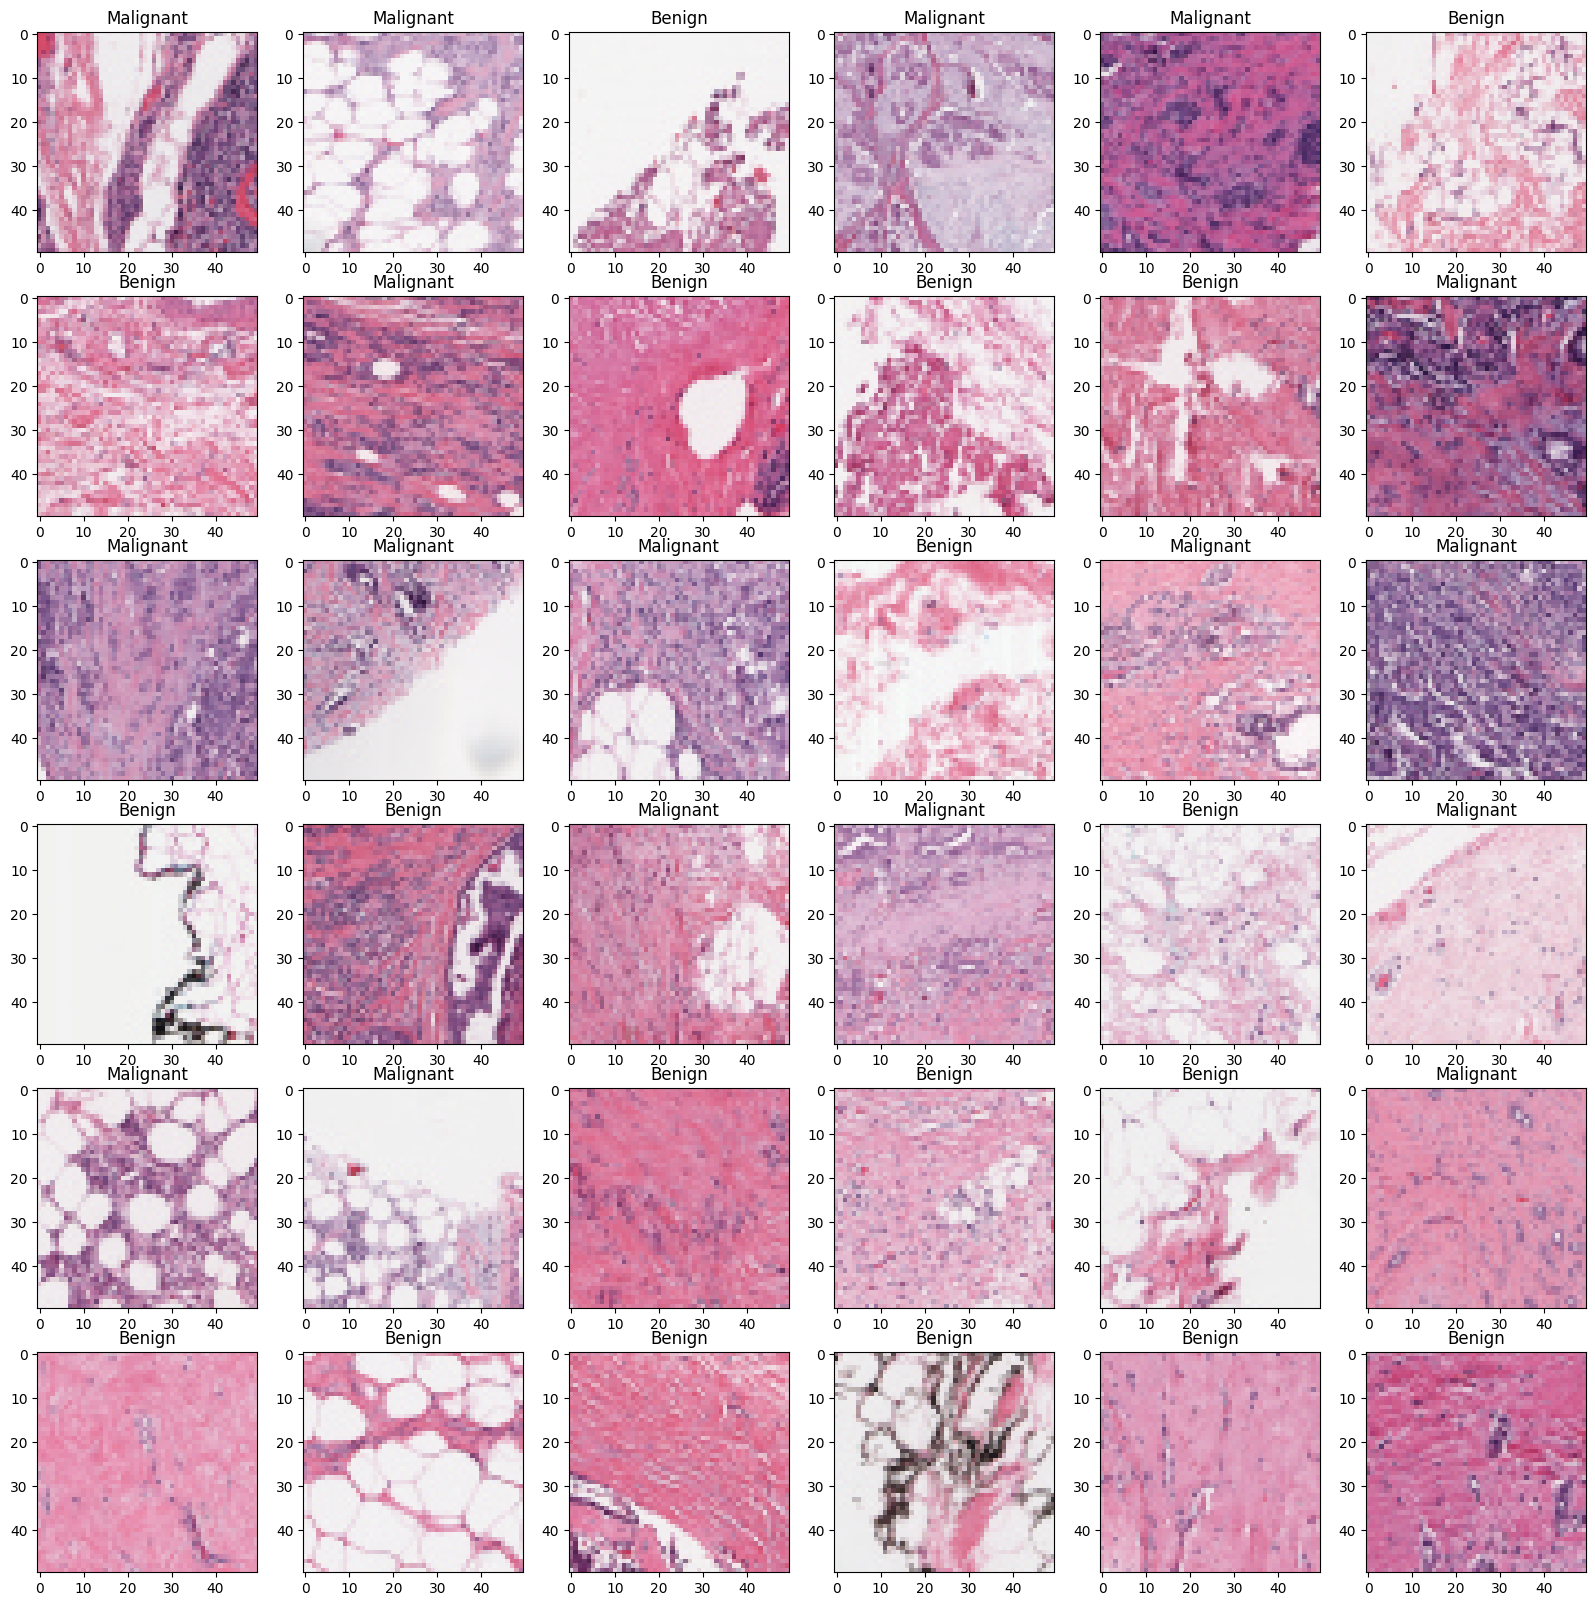

In [96]:
#plot some images
imgs_0=X_train[Y_train==0] #Non-cancerous
imgs_1=X_train[Y_train==1] #Cancerous

plt.figure(figsize=(20,20))
for i in range(36):
    plt.subplot(6,6,i+1)
    if Y_train[i]==0:
        title='Benign'
        plt.title(title)
        plt.imshow(X_train[i]/255.0)
    else:
        title='Malignant'
        plt.title(title)
        plt.imshow(X_train[i]/255.0)

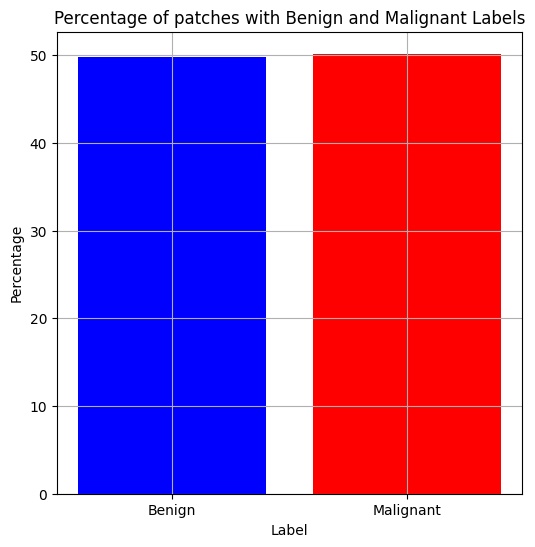

Count of patches showing benign label: 1658
Count of patches showing malignant label: 1670


In [97]:
#Distribution of the percentage of patches with benign and malignant labels
benign_percentage=np.mean(Y_train==0)*100
malignant_percentage=np.mean(Y_train==1)*100

plt.figure(figsize=(6,6))
plt.bar(['Benign','Malignant'],[benign_percentage,malignant_percentage],color=['blue','red'])
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.title('Percentage of patches with Benign and Malignant Labels')
plt.grid(True)
plt.show()

#Count of patches showing Benign and Malignant labels
benign_count=np.sum(Y_train==0)
malignant_count=np.sum(Y_train==1)

print("Count of patches showing benign label:", benign_count)
print("Count of patches showing malignant label:", malignant_count)

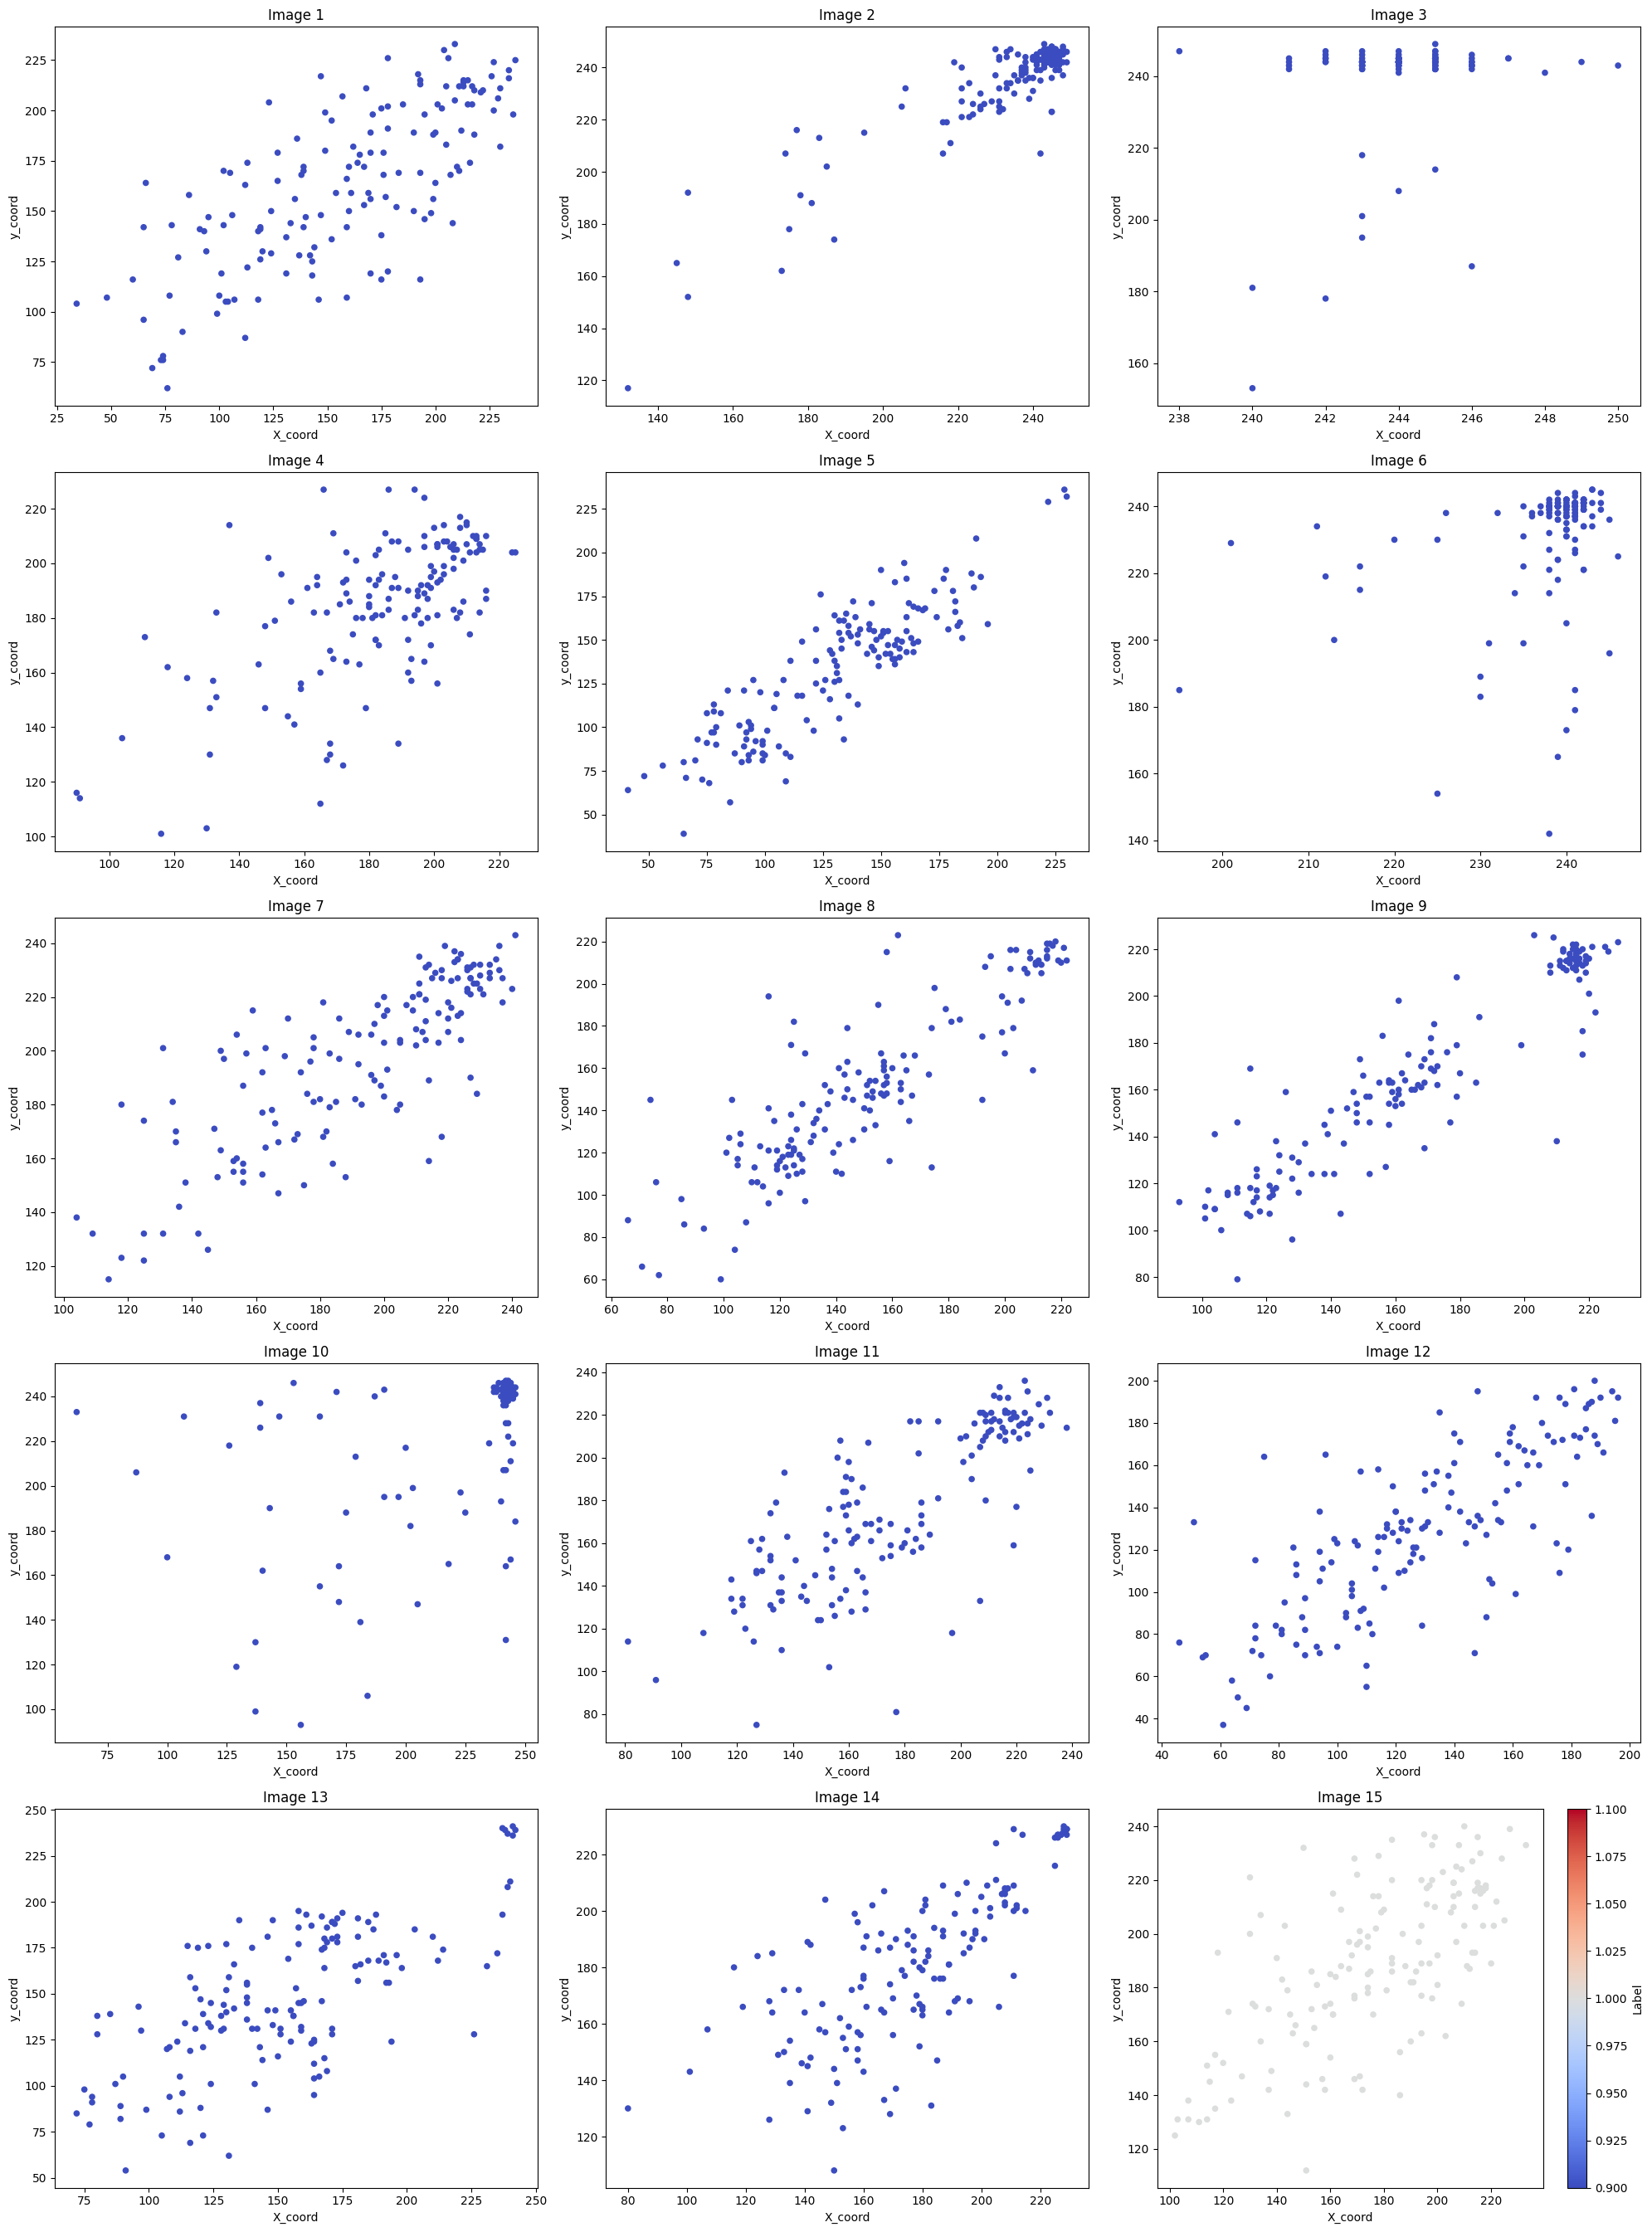

In [98]:
#scatter plot for each tissue slice
plt.figure(figsize=(20,27))
for i in range(15):
    plt.subplot(5,3,i+1)
  #Flatten the coordinates
    X_coords=X_train[i][:,0].flatten()
    y_coords=X_train[i][:,1].flatten()
    labels=np.full_like(X_coords,Y_train[i]) #Use the same label for all points in the patch
    plt.scatter(X_coords,y_coords,c=labels,cmap='coolwarm',s=20)
    plt.xlabel('X_coord')
    plt.ylabel('y_coord')
    plt.title('Image {}'.format(i+1))

plt.tight_layout()
plt.colorbar(label='Label')
plt.show()

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [4]:
from glob import glob
data1 = glob('/kaggle/working/training/**/*.png', recursive=True)
data2 = glob('/kaggle/working/testing/**/*.png', recursive=True)

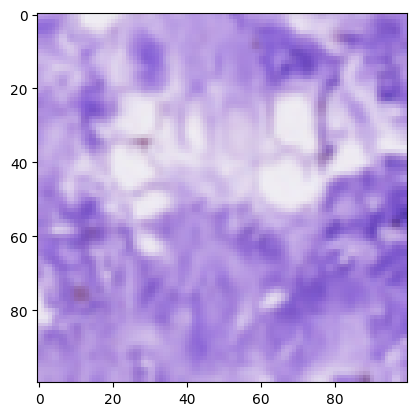

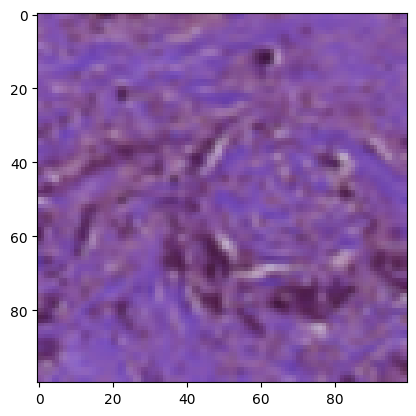

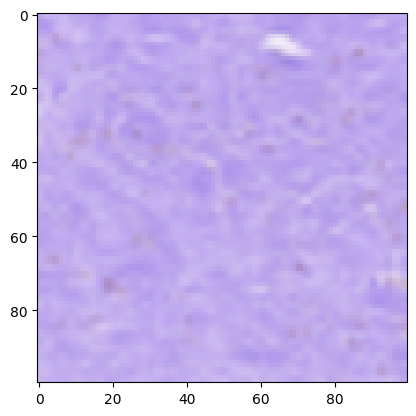

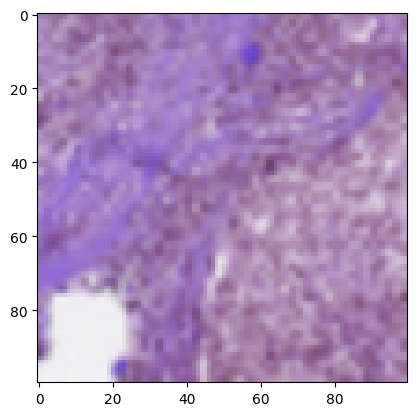

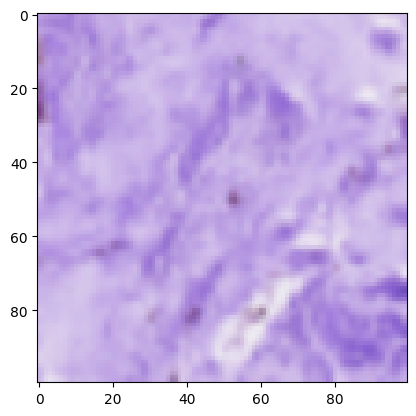

In [6]:
import cv2
import matplotlib.pyplot as plt
for i in data1[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(100,100))
    plt.imshow(img_1,cmap='binary')
    plt.show()

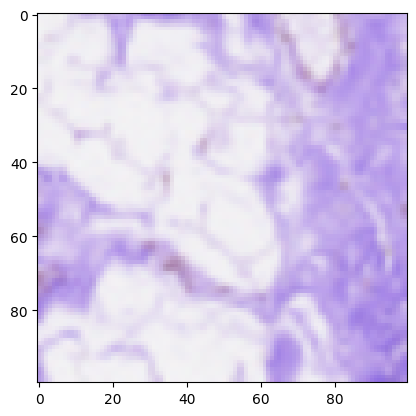

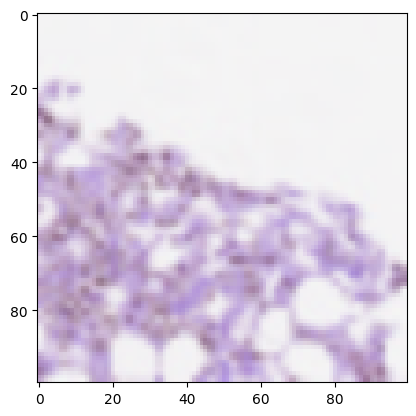

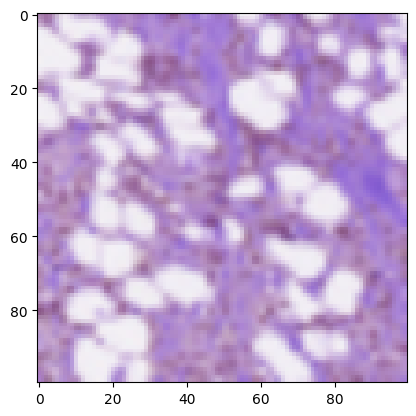

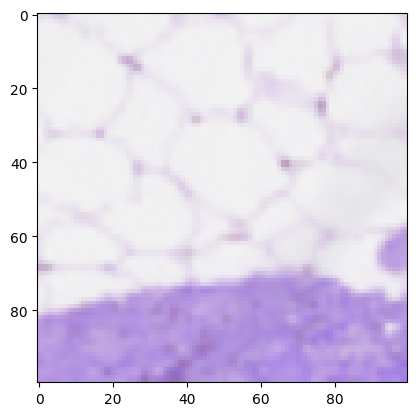

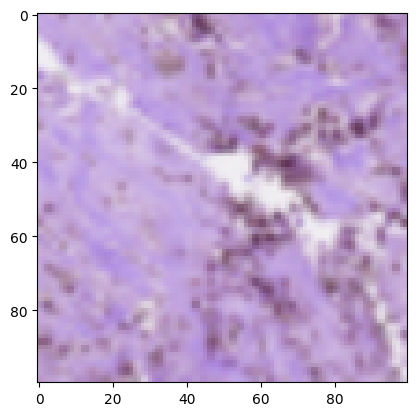

In [7]:
import cv2
import matplotlib.pyplot as plt
for i in data2[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(100,100))
    plt.imshow(img_1,cmap='binary')
    plt.show()

In [30]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess images and labels
def load_images_and_labels(data):
    images = []
    labels = []
    for i in data:
        if i.endswith('.png'):
            label = int(i[-5])  # Extract label from file name
            img = cv2.imread(i)
            img_1 = cv2.resize(img, (100, 100))
            images.append(img_1)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess images and labels from training and testing datasets
x_train, y_train = load_images_and_labels(data1[:15000])
x_test, y_test = load_images_and_labels(data2[:15000])

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)


In [31]:
print("Training Data Shape: ",x_train.shape)
print("Validating Data Shape: ",x_val.shape)

Training Data Shape:  (3328, 100, 100, 3)
Validating Data Shape:  (832, 100, 100, 3)


In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dropout

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same',input_shape=(100,100,3)))
model.add(BatchNormalization())
# model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same',input_shape=(50,50,3)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(2,activation='softmax'))

In [33]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Specify the input shape
# input_shape = (100, 100, 3)  # Example input shape
# model.build(input_shape)

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,386,378 (39.62 MB)

 Trainable params: 10,385,354 (39.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [99]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def modelEfficientNetB0():
    model = Sequential()
    model.add(EfficientNetB0(include_top=False, weights="imagenet", input_shape=(100, 100, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation="sigmoid"))  # Change the number of neurons to 1 for binary classification
    return model

model = modelEfficientNetB0()
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [100]:
model.compile(Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [102]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.0972 - loss: 2.4363 - val_accuracy: 0.1058 - val_loss: 2.4684
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1895 - loss: 2.2309 - val_accuracy: 0.1010 - val_loss: 2.4999
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2763 - loss: 2.0621 - val_accuracy: 0.1034 - val_loss: 2.3642
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3884 - loss: 1.8394 - val_accuracy: 0.1094 - val_loss: 3.8126
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5414 - loss: 1.4694 - val_accuracy: 0.1082 - val_loss: 2.3884
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6654 - loss: 1.0507 - val_accuracy: 0.1058 - val_loss: 3.6911
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7848 - loss: 0.6361 - val_accuracy: 0.1154 - val_loss: 3.1808
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8555 - loss: 0.4600 - val_ac

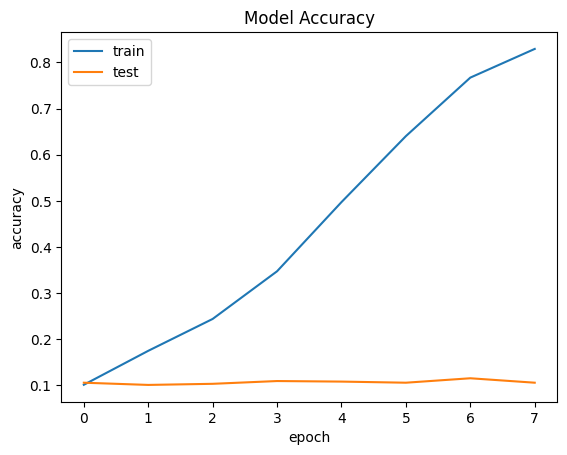

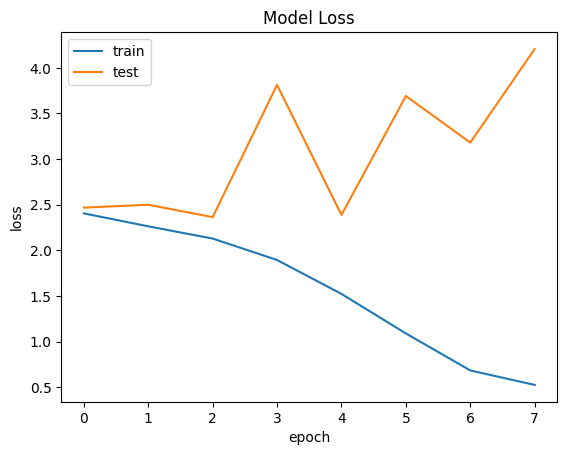

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [106]:
import pandas as pd

#Make predictions on the test data
predictions=model.predict(x_test)

#Get class labels
class_labels=np.argmax(predictions,axis=1)

#Directory containing test images
#test_dir="/content/gdrive/MyDrive/Projects/MateRate/test"
#List all files in the test directory
test_filenames=os.listdir("/kaggle/working/test_dir")

#create a dataframe to store results
results_df=pd.DataFrame(columns=['Image_Filename','Predicted_Class'])

#Loop through the predictions and filenames and add them to the DataFrame
for i in range(len(test_filenames)):
    results_df.loc[i]={'ImageFilename':test_filenames[i],
                                'Predicted_Class':class_labels[i]}

# Save the DataFrame to CSV
results_df.to_csv("/kaggle/working/results.csv",index=False)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
